In [ ]:
import pandas as pd

In [ ]:
# prompt: mount drive and load flood.csv

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/flood.csv')
print(df.head())

Mounted at /content/drive
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ...  DrainageSyste

In [9]:
# Step 1: Remove duplicate rows (if any)
df.drop_duplicates(inplace=True)

# Step 2: Check and fill missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

# Fill missing values with median (can change to mean if preferred)
df.fillna(df.median(numeric_only=True), inplace=True)

# Step 3: Remove any negative values (assuming scores must be >= 0)
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df = df[df[col] >= 0]

# Step 4 (Optional): Clip outliers beyond 99th percentile
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    upper_limit = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=upper_limit)

print("✅ Cleaning complete. Final shape:", df.shape)



Missing values per column:
 MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64
✅ Cleaning complete. Final shape: (50000, 21)


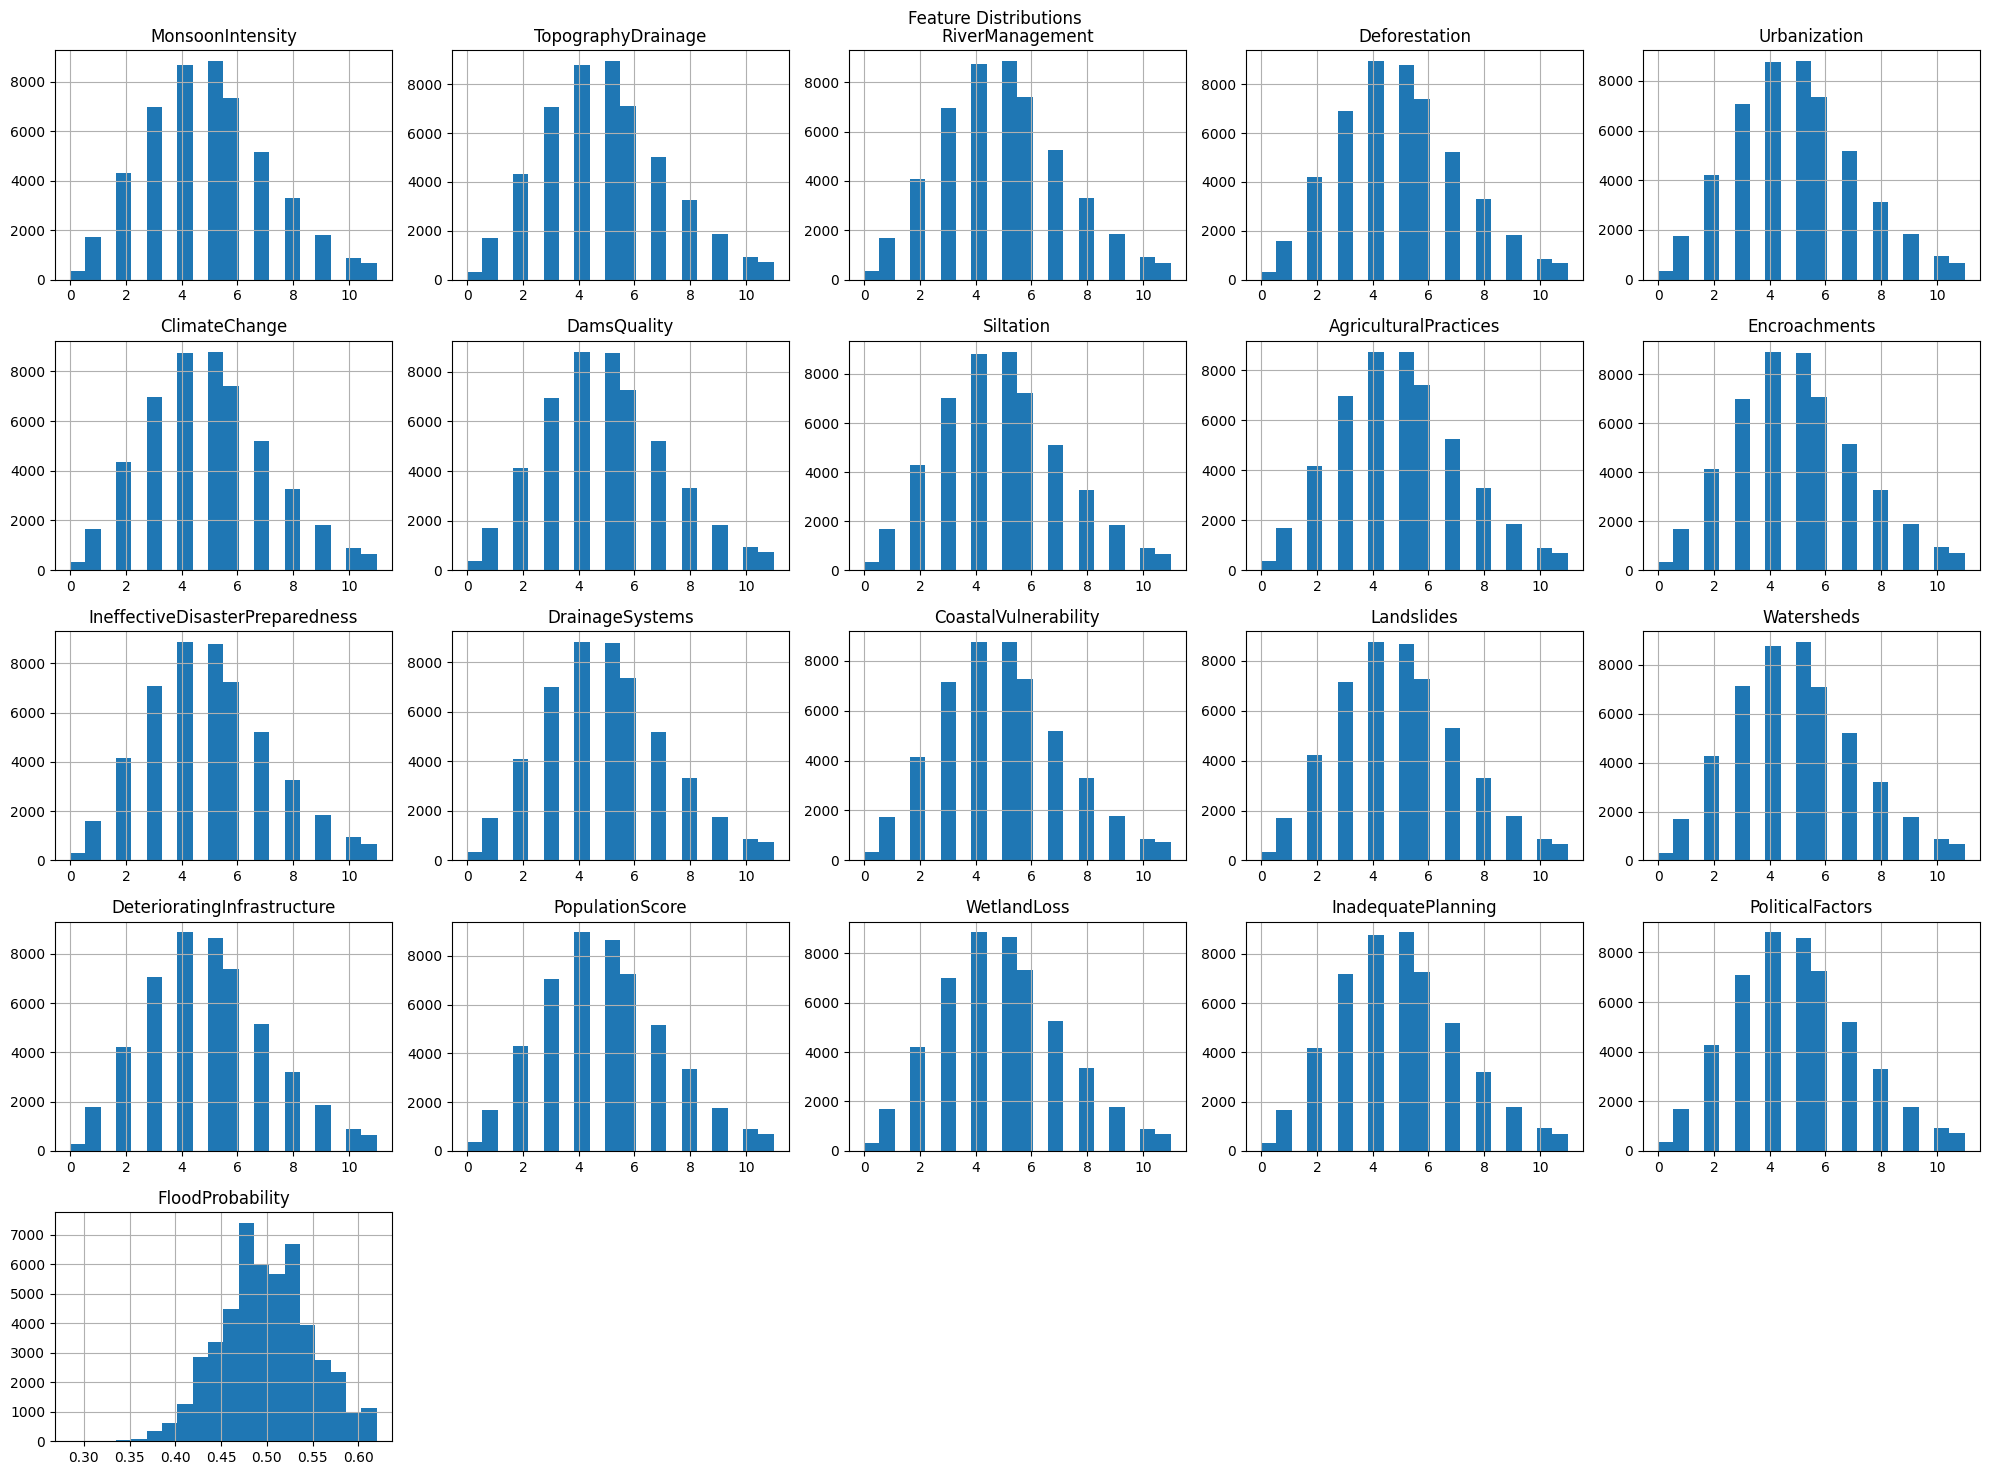

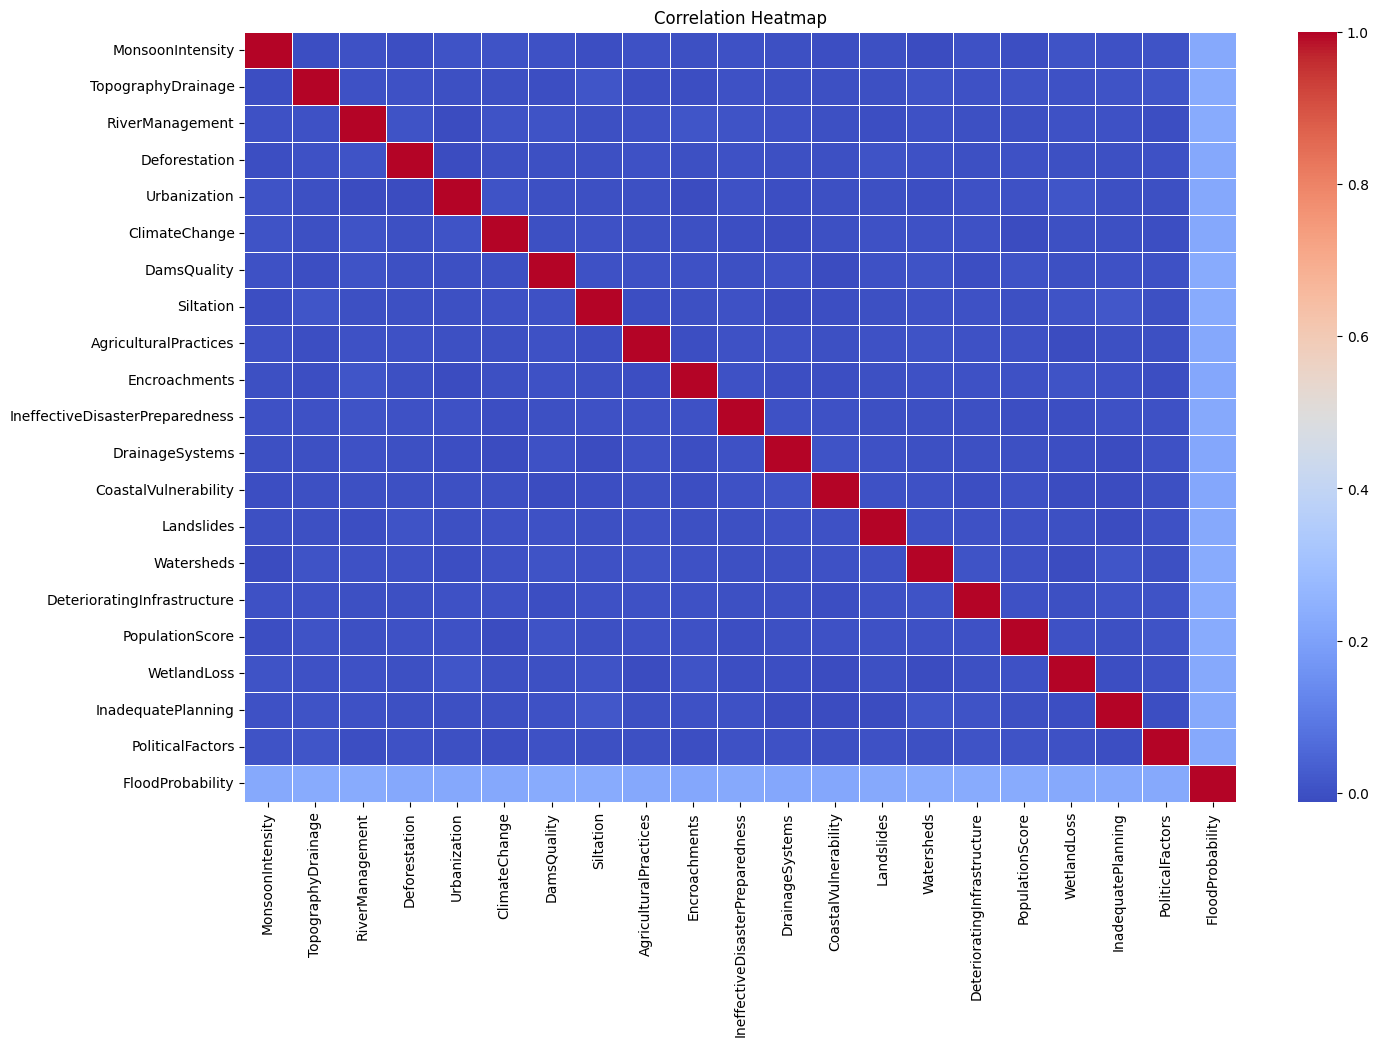

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is already loaded, for example:
# df = pd.read_csv('flood.csv')

# Plot histogram of features
df.hist(bins=20, figsize=(20,15))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [14]:
# 🎯 5. Binary Classification Target
df['FloodRisk'] = (df['FloodProbability'] > 0.5).astype(int)


In [32]:
from sklearn.preprocessing import StandardScaler

# Assuming df is already loaded
X = df.drop(['FloodProbability', 'FloodRisk'], axis=1)
y = df['FloodRisk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [18]:
from sklearn.model_selection import train_test_split

# Assuming X_scaled and y are defined
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train model with serial processing
rf_serial = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
rf_serial.fit(X_train, y_train)

# Train model with parallel processing
rf_parallel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_parallel.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)


Random Forest (Serial) Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5260
           1       0.92      0.86      0.89      4740

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



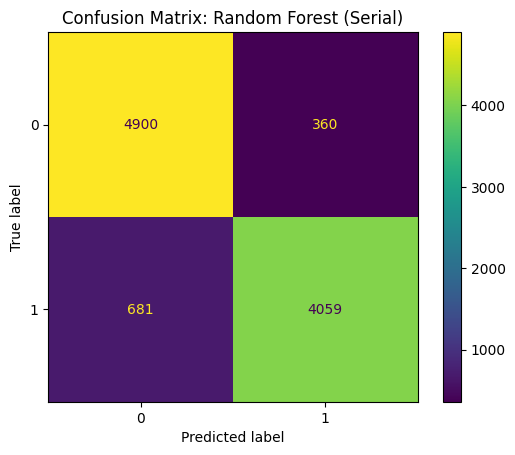


Random Forest (Parallel) Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5260
           1       0.92      0.86      0.89      4740

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



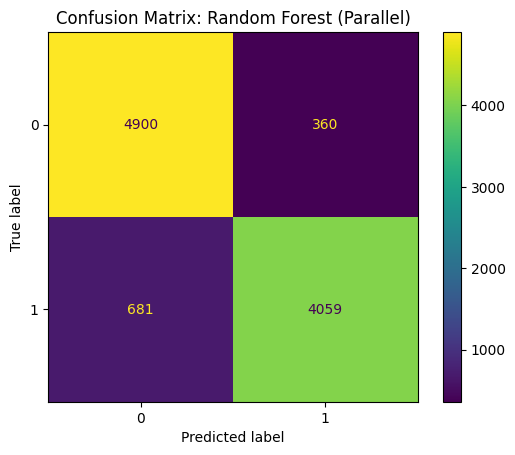

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

evaluate_model(rf_serial, "Random Forest (Serial)")
evaluate_model(rf_parallel, "Random Forest (Parallel)")


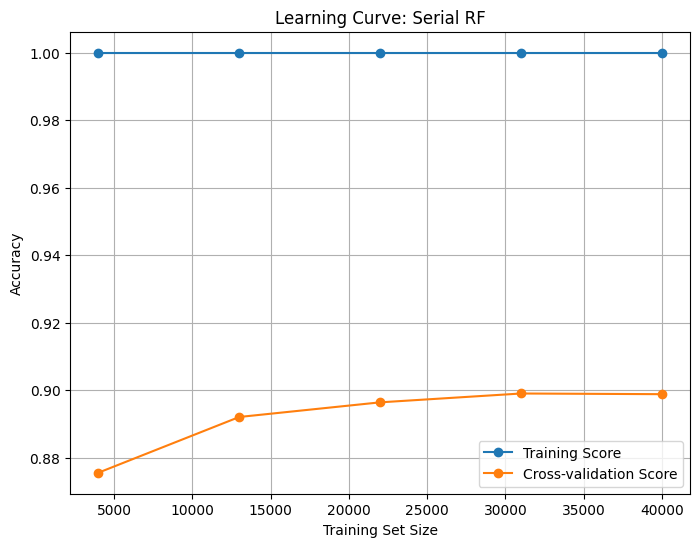

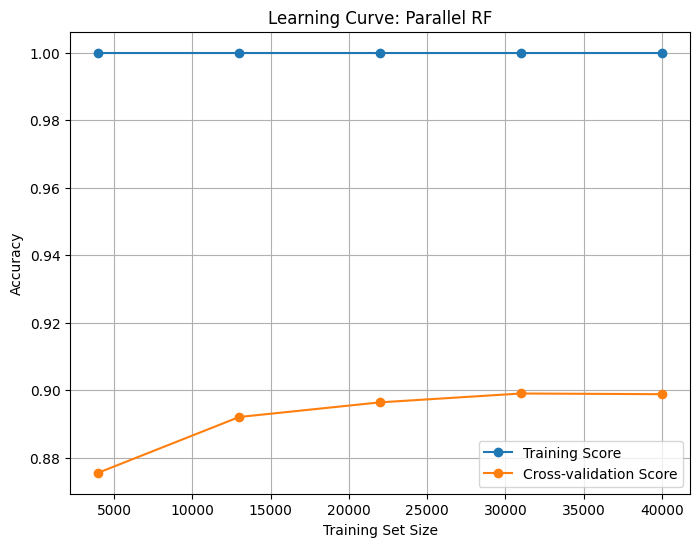


Average CV Accuracy (Serial RF): 0.8988
Average CV Accuracy (Parallel RF): 0.8988

⏱️ Training Time (Serial RF): 7.7113 seconds
⏱️ Training Time (Parallel RF): 6.7595 seconds


In [35]:
# 📚 Learning Curve Plot
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation Score")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(rf_serial, "Learning Curve: Serial RF")
plot_learning_curve(rf_parallel, "Learning Curve: Parallel RF")

# 🔁 Additional: Cross-Validation Accuracy Score (Average)
from sklearn.model_selection import cross_val_score

serial_scores = cross_val_score(rf_serial, X_scaled, y, cv=5, scoring='accuracy', n_jobs=1)
parallel_scores = cross_val_score(rf_parallel, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nAverage CV Accuracy (Serial RF): {serial_scores.mean():.4f}")
print(f"Average CV Accuracy (Parallel RF): {parallel_scores.mean():.4f}")

import time

# Measure training time for serial model
start_serial = time.time()
rf_serial.fit(X_train, y_train)
end_serial = time.time()
serial_time = end_serial - start_serial

# Measure training time for parallel model
start_parallel = time.time()
rf_parallel.fit(X_train, y_train)
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

print(f"\n⏱️ Training Time (Serial RF): {serial_time:.4f} seconds")
print(f"⏱️ Training Time (Parallel RF): {parallel_time:.4f} seconds")
